In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB import Dist_KL_UCB
from KL_UCB import KL_UCB
import os
from multiprocess import Pool

n_runs = 100
T = 5000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1
sd = 0.1
kl_distributions = [sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))]
for i in range(len(rwd_means)):
    kl_distributions[i].random_state = np.random.RandomState(seed=1)
distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [5]:
def worker(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_kl_ucb = np.zeros((len(job_runs), len(sigmas), T))
    regrets_kl_ucb = np.zeros((len(job_runs), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for b in range(len(sigmas)):
            distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[b])
            distkl.run()
            mean_regrets_dist_kl_ucb[run-job_runs[0], b, :] = np.mean(distkl.regrets, axis=0)
        kl = KL_UCB(T, kl_distributions)
        kl.run()
        regrets_kl_ucb[run-job_runs[0], :] = kl.regret
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_kl_ucb, regrets_kl_ucb

In [6]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
regrets_kl_ucb = np.zeros((n_runs, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_kl_ucb_unconcat = [result[0] for result in results]
regrets_kl_ucb_unconcat = [result[1] for result in results]
np.concatenate(mean_regrets_dist_kl_ucb_unconcat, out=mean_regrets_dist_kl_ucb)
np.concatenate(regrets_kl_ucb_unconcat, out=regrets_kl_ucb)

end_run_t = time.time()

# for run in range(n_runs):
#     start_run_t = time.time()
#     G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
#     nodes = list(G.nodes)
#     for i in nodes:
#         G.add_edge(i,i) 
#     for sig in range(len(sigmas)):
#         distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
#         distkl.run()
#         mean_regrets_dist_kl_ucb[run, sig, :] = np.mean(distkl.regrets, axis=0)

#     kl = KL_UCB(T, kl_distributions)
#     kl.run()
#     regrets_kl_ucb[run, :] = kl.regret
#     end_run_t = time.time()
#     print(f'finished run {run} in {end_run_t - start_run_t}sec')

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
mean_regrets_over_all_runs_kl_ucb = np.mean(regrets_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_kl_ucb = np.std(regrets_kl_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

finished run 0 in 141.61977219581604sec
finished run 1 in 146.8572859764099sec
finished run 6 in 153.39404892921448sec
finished run 2 in 156.64833092689514sec
finished run 7 in 157.82219791412354sec
finished run 3 in 165.30293202400208sec
finished run 5 in 166.81463408470154sec
finished run 4 in 176.4681739807129sec
finished run 9 in 113.43309998512268sec
finished run 8 in 120.18295884132385sec
Total run time = 261.98961877822876sec


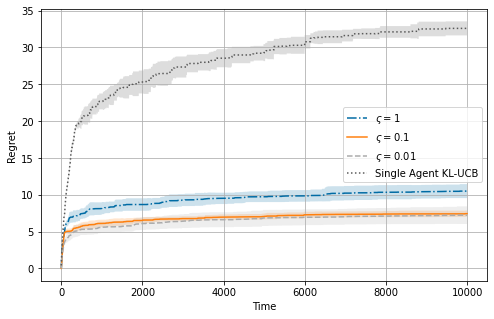

In [7]:
plt.figure(figsize=(8,5))
linestyles = ['-.', '-', '--']
for sig in range(len(sigmas)):
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], linestyles[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
plt.plot(time_axis, mean_regrets_over_all_runs_kl_ucb, ':', label="Single Agent KL-UCB")
plt.fill_between(time_axis, mean_regrets_over_all_runs_kl_ucb-std_regrets_over_all_runs_kl_ucb, mean_regrets_over_all_runs_kl_ucb+std_regrets_over_all_runs_kl_ucb, alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.grid()
plt.savefig("./.out/dist_KL_vs_single_KL.pdf", bbox_inches='tight')